In [ ]:
from google.colab import drive , files

In [ ]:
drive.mount("/content/MyDrive/")

Mounted at /content/MyDrive/


In [ ]:
%cd '/content/MyDrive/MyDrive/sound_text/'

/content/MyDrive/MyDrive/sound_text


In [ ]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from imutils import paths

In [ ]:
trainDir = 'sound_text_dataset/train/'
samples , sample_rate = librosa.load(trainDir + 'bird/1009.wav' ,sr=16000)
ipd.Audio(samples , rate=sample_rate)
print(sample_rate)
print(samples)

16000
[-0.00396729 -0.00354004 -0.00131226 ...  0.00918579  0.01010132
  0.0112915 ]


In [ ]:
samples = librosa.resample(samples , sample_rate , 8000)
ipd.Audio(samples , rate = 8000)

In [ ]:
labels = os.listdir(trainDir)
print(labels)

['bird', 'eight', 'dog', 'bed', 'cat', 'down']


In [ ]:
no_of_recordings = []
for label in labels:
  waves = [i for i in os.listdir(trainDir + '/' + label) if i.endswith('.wav')]
  no_of_recordings.append(len(waves))

print(len(no_of_recordings))

6


In [ ]:
labels = ['bird', 'eight', 'dog', 'bed', 'cat', 'down']

(array([  0.,   0.,   0.,   0.,   0., 120.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

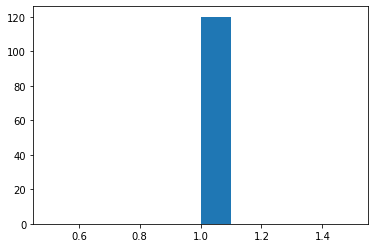

In [ ]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(trainDir + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(trainDir + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [ ]:
all_wave = []
all_labels = []


for label in labels:
  print(label)
  waves = [i for i in os.listdir(trainDir+'/'+label) if i.endswith('wav')]
  for wav in waves:
    samples ,  sample_rate = librosa.load(trainDir + '/' + label + '/' + wav , sr=16000)
    samples = librosa.resample(samples , sample_rate ,8000)
    if len(samples) == 8000:
      all_wave.append(samples)
      all_labels.append(label)


print(len(all_labels))
print(len(all_wave))

bird
eight
dog
bed
cat
down
120
120


#Labels processing

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

le = LabelEncoder()
y = le.fit_transform(all_labels)
print(y)
classes = list(le.classes_)
print(classes)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4]
['bed', 'bird', 'cat', 'dog', 'down', 'eight']


In [ ]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))
#print(y)

#reshape to 3d

In [ ]:
all_wave = np.array(all_wave).reshape(-1 , 8000 , 1)

In [ ]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(np.array(all_wave) , np.array(y) , stratify=y , test_size = 0.2 , random_state=777 , shuffle=True )

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history=model.fit(x_train, y_train ,epochs=100, batch_size=32, validation_data=(x_test,y_test))

Epoch 1/100
3/3 [==============================] - 18s 670ms/step - loss: 1.7931 - accuracy: 0.1628 - val_loss: 1.7906 - val_accuracy: 0.1667
Epoch 2/100
3/3 [==============================] - 1s 273ms/step - loss: 1.7870 - accuracy: 0.1784 - val_loss: 1.7898 - val_accuracy: 0.1667
Epoch 3/100
3/3 [==============================] - 1s 262ms/step - loss: 1.7840 - accuracy: 0.1315 - val_loss: 1.7859 - val_accuracy: 0.1250
Epoch 4/100
3/3 [==============================] - 1s 262ms/step - loss: 1.7659 - accuracy: 0.2435 - val_loss: 1.7773 - val_accuracy: 0.1667
Epoch 5/100
3/3 [==============================] - 1s 259ms/step - loss: 1.7407 - accuracy: 0.1784 - val_loss: 1.7607 - val_accuracy: 0.2083
Epoch 6/100
3/3 [==============================] - 1s 261ms/step - loss: 1.7014 - accuracy: 0.2656 - val_loss: 1.7297 - val_accuracy: 0.3750
Epoch 7/100
3/3 [==============================] - 1s 269ms/step - loss: 1.6287 - accuracy: 0.3411 - val_loss: 1.6657 - val_accuracy: 0.3333
Epoch 8/100


In [ ]:
model.save('sound_text.hdf5')

#Testing

In [ ]:
from keras.models import load_model
model = load_model("sound_text.hdf5")

In [ ]:
testDir = 'sound_text_dataset/test/'

In [ ]:
def predict(audio):
  prob=model.predict(audio.reshape(1,8000,1))
  index=np.argmax(prob[0])
  return classes[index]

In [ ]:
import random
index=random.randint(0,len(x_test)-1)
samples=x_test[index].ravel()
print("Audio:",classes[np.argmax(y_test[index])])
ipd.Audio(samples, rate=8000)

Audio: bed


In [ ]:
print("Text:",predict(samples))

Text: bed
